<ipython-input-3-705d07e9b62b>:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.33333333 0.33333333 0.16666667 ... 0.83333333 0.58333333 0.66666667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[:, 2:] = scaler.fit_transform(df.iloc[:, 2:])
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 36s 80ms/step - loss: 8322.5879 - val_loss: 6409.2954
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 76ms/step - loss: 5904.7656 - val_loss: 4868.0151
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 74ms/step - loss: 4586.8716 - val_loss: 4001.0798
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 74ms/step - loss: 3840.5251 - val_loss: 3565.7871
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - loss: 3486.0127 - val_loss: 3375.0679
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 75ms/step - loss: 3433.5623 - val_loss: 3305.7583
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 75ms/step - loss: 3310.3821 - val_loss: 3286.7917
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 76ms/step - loss: 3267.8945 - val_loss: 3281.5974
Epoch 9/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 74ms/step - loss: 3233.5508 - val_loss: 3279.6851
Epoch 10/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 77ms/step - loss: 3323.5547 - val_loss: 3279.5549
Epoch 11/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 74ms/step - lo

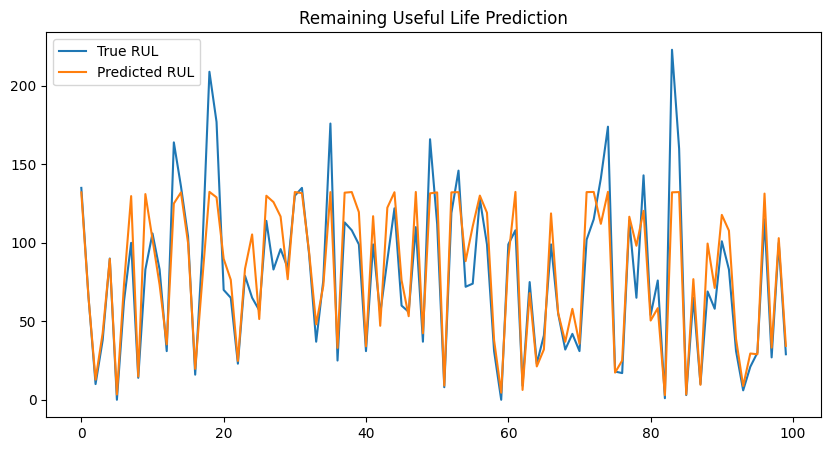

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Step 1: Extract the dataset
zip_path = "/content/archive.zip"
extract_path = "/content/extracted_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Step 2: Load the correct dataset (FD001 for example)
file_path = os.path.join(extract_path, "CMaps/train_FD001.txt")

df = pd.read_csv(file_path, sep=" ", header=None, engine='python')
df.dropna(axis=1, inplace=True)  # Drop empty columns

# Rename columns
columns = ['unit', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + [f'sensor_{i}' for i in range(1, 22)]
df.columns = columns

# Normalize sensor readings
scaler = MinMaxScaler()
df.iloc[:, 2:] = scaler.fit_transform(df.iloc[:, 2:])

# Generate Remaining Useful Life (RUL) target
rul = df.groupby('unit')['cycle'].max().reset_index()
rul.columns = ['unit', 'max_cycle']
df = df.merge(rul, on='unit')
df['RUL'] = df['max_cycle'] - df['cycle']
df.drop('max_cycle', axis=1, inplace=True)

# Prepare data for LSTM model
sequence_length = 50  # Number of past cycles used for prediction
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for unit in data['unit'].unique():
        unit_data = data[data['unit'] == unit].drop(columns=['unit', 'cycle'])
        for i in range(len(unit_data) - sequence_length):
            sequences.append(unit_data.iloc[i:i+sequence_length, :-1].values)
            labels.append(unit_data.iloc[i+sequence_length, -1])
    return np.array(sequences), np.array(labels)

X, y = create_sequences(df, sequence_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(sequence_length, X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

# Evaluate the model
predictions = model.predict(X_test)
plt.figure(figsize=(10,5))
plt.plot(y_test[:100], label='True RUL')
plt.plot(predictions[:100], label='Predicted RUL')
plt.legend()
plt.title("Remaining Useful Life Prediction")
plt.show()

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("MAE:", mean_absolute_error(y_test, predictions))
print("RMSE:", np.sqrt(mean_squared_error(y_test, predictions)))


MAE: 17.766929626464844
RMSE: 28.973908361190354
